# The HBV Model

For the simulation of anticipated future discharge, the Hydrologiska Byråns Vattenbalansavdelning (HBV) model was selected. Developed by Sten Bergström (in 1992) (Wetterhall, 2017), the HBV framework is classified as a semi-distributed conceptual rainfall–runoff model. In this approach, a catchment is represented by a network of interconnected storage reservoirs that emulate the hydrological processes governing water movement. Calibration to diverse catchments is achieved via adjustment of nine model parameters. The HBV model requires three meteorological forcing inputs—precipitation, air temperature and potential evapotranspiration—to drive its internal mass-balance computations. Each parameter modulates a specific hydrological process, enabling the HBV model to reproduce observed hydrographs across a range of climatic and physiographic 

The nine calibration parameters are as follows:

*Table 3.1: HBV model parameters.*

| **Parameter**        | **Description**                                          |
|----------------------|----------------------------------------------------------|
| $I_{\text{max}}$     | Maximum soil moisture storage capacity                   |
| $C_{\text{e}}$       | Evapotranspiration correction factor                     |
| $S_{\text{u,max}}$   | Upper zone storage capacity                              |
| $\beta$              | Nonlinearity exponent governing soil moisture runoff     |
| $P_{\text{max}}$     | Threshold precipitation for snow accumulation            |
| $T_{\text{lag}}$     | Temperature threshold for snowmelt delay                 |
| $K_{\text{f}}$       | Recession coefficient for the upper storage reservoir    |
| $K_{\text{s}}$       | Recession coefficient for the lower storage reservoir    |
| $F_{\text{M}}$       | Fractional melt coefficient for snowpack                 |

<figure>
  <img src="figures/HBV.png" width="600">
  <figcaption><b>Figure 3.1:</b> The HBV model. Taken from M. Hrachowits, n.d., CC BY 4.0.
</figure>

## Model Calibration Methodology
The HBV model uses simplified representations of hydrological processes, with parameters that often cannot be directly measured. To ensure the model accurately reflects observed discharge patterns, an automated calibration approach is applied. This approach focuses on accuracy during low-flow conditions (below 500 m³/s) and on the correct timing of these low-flow events.

The calibration combines a multi-criteria objective function with a structured, step-by-step procedure. This leads to the identification of optimized parameter sets that enhance the model’s performance (Yilmaz et al., 2010).

## Setup and Data Preparation

In [1]:
#some general python and eWaterCycle libraries need to be imported
%matplotlib inline
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display
import xarray as xr
from scipy.stats import wasserstein_distance

# Niceties
from rich import print
from tqdm import tqdm


# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

# Optional: Data Assimilation
# If not installed, uncomment below to install
# !pip install ewatercycle-da
from ewatercycle_DA import DA

import nbformat
from critical_days_module import droughts

## Choose region and time period

<Axes: >

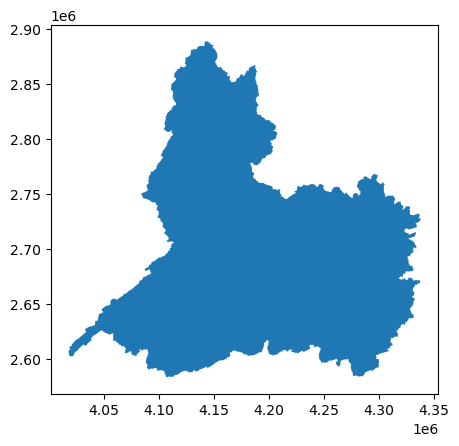

In [2]:
# name of the catchment
basin_name = "FR000119"

# defining dates for calibration
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

#Define Catchment Area
shapefile_path = Path.home() / "projects" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [3]:
# # Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 Forcing

In [4]:
forcing_dir = Path.home() / "projects/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/forcing/work/diagnostic/script"
ERA5_forcing = sources["LumpedMakkinkForcing"].load(directory=forcing_dir)

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [5]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

## Ensemble Initialization and Parameter Sampling

### Calibration Algorithm
Model calibration using the ensemble method involves creating an ensemble of multiple models, this method is taken from eWatercycle and Hut, 2025. Instead of a single one. Each "ensemble member" is assigned its own unique set of parameters. These parameters are created by generating random values within predefined ranges. All models within this ensemble can then be run simultaneously with a single command, like ensemble.update(). After these runs, an objective function is applied to each model's output to quantify its "goodness of fit" by comparing it to the observed dicharge data. The best set of parameters is then identified as the combination that yields the lowest objective function score.

In [6]:
# Define HBV parameter bounds and names
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
p_min = np.array([0.0,  0.2,   40.0,  0.5,   0.001,   1.0,   0.01,  0.0001,  0.01])
p_max = np.array([8.0,  1.0,  800.0,  4.0,   0.3,    10.0,   0.1,   0.01,   10.0])

n_particles = 1000  # ensemble size

# Sample random parameters for each particle within bounds
parameters = np.zeros((len(param_names), n_particles))
for j in range(len(param_names)):
    parameters[j, :] = np.random.uniform(p_min[j], p_max[j], size=n_particles)

In [7]:
# Create ensemble and initialize each member with HBV model and unique parameters
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup() 

# Prepare setup arguments for each particle (each gets its parameter set)
setup_kwargs_list = [{'parameters': parameters[:, i]} for i in range(n_particles)]

# Initialize all ensemble members with the HBVLocal model, forcing data, and parameters
ensemble.initialize(model_name=["HBVLocal"] * n_particles,
                    forcing=[ERA5_forcing] * n_particles,
                    setup_kwargs=setup_kwargs_list) 

ref_model = ensemble.ensemble_list[0].model

# Generate config file with first parameter set
config_file, _ = ref_model.setup(parameters=parameters[:, 0])

# Initialize model
ref_model.initialize(config_file)

## Running the Ensemble Simulation

In [8]:
# Determine number of time steps in the simulation period
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step)

time_index = []           # list to store timestamps for each time step
ensemble_Q_outputs = []   # list to store discharge arrays for each time step

for step in range(n_timesteps):
    # Record current model time
    current_time = pd.Timestamp(ref_model.time_as_datetime.date())
    time_index.append(current_time)
    
    # Advance all models by one time step and collect their discharge values
    ensemble.update()  # update all ensemble members by one step
    Q_values = np.array(ensemble.get_value("Q")).flatten()  # discharge of all particles
    Q_values_m3s = Q_values * basin_area * 1000 / 86400  # convert to m3/s
    ensemble_Q_outputs.append(Q_values_m3s)

ensemble.finalize()

# Convert collected outputs to a DataFrame
Q_array = np.array(ensemble_Q_outputs)  # shape: (n_timesteps, n_particles)
df_ensemble = pd.DataFrame(
    data=Q_array, 
    index=pd.DatetimeIndex(time_index), 
    columns=[f"particle_{i}" for i in range(n_particles)]
)

## Defining the Calibration Objective

### Objective Functions
To accurately represent both the size and timing of low-flow events, a multi-criteria approach is used. The use of multiple performance measures helps to achieve a better balance between the number of calibration parameters and the quantity of the available observational data. This makes the parameter estimation more reliable than when using a single measure (Yilmaz et al., 2010). Two specific objective functions are selected for their ability to reflect low-flow conditions and timing accuracy.

#### 1. For Low-Flow Magnitude and General Fit
To make sure the low-flow values are most accurate the model performance will be evaluated using the Nash–Sutcliffe Efficiency (NSE). It will be applied to log-transformed discharge values. The logarithmic transformation increases sensitivity to low-flow conditions (Yilmaz et al., 2010). NSE is based on squared differences. Which causes it to remain numerically stable under transformation and means it is less affected by unit conversions (Santos et al., 2018).

$$
\log\text{-NSE} = 1 - \frac{\sum_t \left(\log Q_{\text{sim},t} - \log Q_{\text{obs},t}\right)^2}{\sum_t \left(\log Q_{\text{obs},t} - \log \overline{Q}_{\text{obs}}\right)^2}
$$

Where:

- $Q_{\text{sim},t}$ is the simulated discharge at time $t$, where $Q_{\text{sim},t} > 0$.
- $Q_{\text{obs},t}$ is the observed discharge at time $t$, where $Q_{\text{obs},t} > 0$.
- $\overline{Q}_{\text{obs}}$ is the mean of the log-transformed observed discharges.

> **Note:** Only positive discharge values are used to ensure the logarithm is defined. A higher log-NSE indicates better model performance, especially under low-flow conditions.

#### 2. For Timing and Low-Flow Properties
To improve the accuracy of the low-flow discharge timeline, the Earth Mover's Distance (EMD) will be used. It is also known as the Wasserstein Distance (WD). It compares the temporal distributions of droughts between observed and simulated data. By minimizing the EMD, the calibration process aligns the timing of low-flow periods (Ehret & Zehe, 2011).

For discrete distributions $P$ and $Q$, the Earth Mover's Distance (EMD) is defined as:

$$
\text{EMD}(P, Q) = \min_{f_{ij} \geq 0} \sum_{i,j} f_{ij} \, d_{ij}
$$

Subject to:

$$
\sum_j f_{ij} = P_i, \quad \sum_i f_{ij} = Q_j
$$

Where:

- $P_i$ and $Q_j$ are discrete probability distributions of drought features (e.g., durations or deficits) for observed and simulated data, respectively.
- $f_{ij}$ is the amount of "mass" moved from bin $i$ in $P$ to bin $j$ in $Q$.
- $d_{ij}$ is the temporal distance or difference in drought duration between bins $i$ and $j$.

#### Multi-Criteria Integration

The two objective functions will be combined using a multi-criteria framework. A weighted sum is used, where each criterion is given a weight to reflect its relative importance. This allows the calibration to balance overall low-flow accuracy with the timing and characteristics of drought events.

To combine log-NSE and EMD into a single optimization objective while emphasizing low-flow quantity (not just timing), the following **weighted error function** $J$ is defined:

$$
J = w_{\log \text{NSE}} \cdot (1 - \log \text{NSE}) + w_{\text{EMD}} \cdot \text{EMD}
$$

Where:

- $(1 - \log \text{NSE})$ transforms the log-NSE (normally a maximization metric) into a minimization objective.
- $w_{\log \text{NSE}}$ and $w_{\text{EMD}}$ are weights that control the emphasis between low-flow magnitude accuracy and timing.

*Weight setting:*

Since low-flow magnitude accuracy is the primary focus:

$w_{\log \text{NSE}} > w_{\text{EMD}}$

In this study the weight setting is as follows:

$w_{\log \text{NSE}} = 0.7$, $w_{\text{EMD}} = 0.3$

In [12]:
def calibration_objective(simulated_series: pd.Series, observed_series: pd.Series,
                          w_lognse: float = 0.7, w_emd: float = 0.3) -> float:
    """
    Calibrate model by combining:
    - log-NSE: performance during low flows
    - EMD: match drought event characteristics (timing)
    Weights w_lognse and w_emd define the importance of each.
    Lower total_score indicates better calibration.
    """

    # Align indices
    sim = simulated_series.loc[observed_series.index]
    obs = observed_series

    # 1. log-NSE
    sim_pos = sim[sim > 0]
    obs_pos = obs[obs > 0]
    common_index = sim_pos.index.intersection(obs_pos.index)
    sim_log = np.log(sim_pos.loc[common_index])
    obs_log = np.log(obs_pos.loc[common_index])
    
    numerator = np.sum((sim_log - obs_log) ** 2)
    denominator = np.sum((obs_log - np.mean(obs_log)) ** 2)
    log_nse = 1 - (numerator / denominator) if denominator != 0 else np.inf
    error_nse = 1 - log_nse  # to be minimized

    # 2. EMD from drought characteristics
    obs_droughts = droughts(obs, basin_name="obs", q_crit=500)
    sim_droughts = droughts(sim, basin_name="sim", q_crit=500)

    obs_durations = pd.DataFrame(obs_droughts)["Duration (days)"].values
    sim_durations = pd.DataFrame(sim_droughts)["Duration (days)"].values
    obs_deficits = pd.DataFrame(obs_droughts)["Cumulative Deficit (m3/s)"].abs().values
    sim_deficits = pd.DataFrame(sim_droughts)["Cumulative Deficit (m3/s)"].abs().values

    emd_duration = wasserstein_distance(obs_durations, sim_durations)
    emd_deficit = wasserstein_distance(obs_deficits, sim_deficits)
    error_emd = emd_duration + emd_deficit

    # Combine with weighted sum
    total_score = w_lognse * error_nse + w_emd * error_emd
    return total_score

In [13]:
print("Q_obs index sample:", Q_obs.index[:3])
print("df_ensemble index sample:", df_ensemble.index[:3])

Q_obs index sample: DatetimeIndex(['2013-11-26', '2013-11-27', '2013-11-28'], dtype='datetime64[ns]', freq=None)

df_ensemble index sample: DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03'], dtype='datetime64[ns]', 
freq=None)

## Evaluating Performance and Selecting the Best Parameter Set

In [14]:
# Evaluate objective for each ensemble member
scores = []

# Same datetime-index
Q_obs.index = Q_obs.index.normalize()
Q_obs.index = Q_obs.index.tz_localize(None)

# Slice only the overlap 
Q_obs_aligned = Q_obs.loc[df_ensemble.index.min():df_ensemble.index.max()]

for i in range(n_particles):
    sim_series = df_ensemble[f"particle_{i}"]

    if sim_series is None or sim_series.empty:
        print(f"Skipping particle_{i} (empty output)")
        scores.append(np.inf)  # Assign a bad score
        continue

    # Use the correct observation series (make sure Q_obs exists and matches in index)
    score = calibration_objective(sim_series, Q_obs_aligned)
    scores.append(score)

scores = np.array(scores)
best_index = np.argmin(scores)              # index of minimum objective value
best_score = scores[best_index]             # lowest score
best_params = parameters[:, best_index]     # parameter set corresponding to best score

print(f"Best score: {best_score:.3f} (part {best_index})")

Best score: 76.459 (part 208)

## Show the Optimal Parameters

In [15]:
print(f"Best objective score: {best_score:.4f}")

# Round best parameters
best_params_list = [round(val, 4) for val in best_params]

# Define parameter descriptions (matches param_names)
param_descriptions = [
    "Maximum intensity",
    "Coefficient of evaporation",
    "Field capacity",
    "Shape coefficient",
    "Maximum percolation rate",
    "Time lag",
    "Fast run-off parameter",
    "Slow run-off parameter",
    "Degree-day factor"
]

# Build DataFrame
df_params = pd.DataFrame({
    "Parameter": param_names,
    "Description": param_descriptions,
    "Value": best_params_list
})

# Reset index and drop it for clean display
df_params.index = [""] * len(df_params)

display(df_params.style.set_table_styles([
    {"selector": "th", "props": [("font-weight", "bold")]}
]))

Best objective score: 76.4591

,Parameter,Description,Value
,Imax,Maximum intensity,7.227100
,Ce,Coefficient of evaporation,0.799000
,Sumax,Field capacity,312.283800
,Beta,Shape coefficient,1.926100
,Pmax,Maximum percolation rate,0.282000
,Tlag,Time lag,3.582100
,Kf,Fast run-off parameter,0.019000
,Ks,Slow run-off parameter,0.005900
,FM,Degree-day factor,6.457300
